# Ten-Bar Truss Weight Minimization
Created by Yi-Ping Chen, last modified in Jan. 2025 for ME341.

In [15]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

### Define functions

In [16]:
# Finite Element Analysis code
def FEA(r):
    length = 9.14  # unit: m
    E = 200e9
    F = np.zeros(12)  # unit: N
    F[3] = -1e7
    F[7] = -1e7

    # Node Table
    n = np.array([
        [2, 1], [2, 0], [1, 1], [1, 0], [0, 1], [0, 0]
    ]) * length

    # Element Connectivity Table
    ec = np.array([
        [3, 5], [1, 3], [4, 6], [2, 4], [3, 4], 
        [1, 2], [4, 5], [3, 6], [2, 3], [1, 4]
    ]) - 1  # Convert to zero-based indexing

    # Initialize element properties
    num_elements = 10
    length_e = np.zeros(num_elements)
    l = np.zeros(num_elements)
    m = np.zeros(num_elements)

    # Compute element lengths and direction cosines
    for i in range(num_elements):
        diff = n[ec[i, 1]] - n[ec[i, 0]]
        length_e[i] = np.linalg.norm(diff)
        l[i] = diff[0] / length_e[i]
        m[i] = diff[1] / length_e[i]

    # Element radius and area
    r = np.concatenate([np.full(6, r[0]), np.full(4, r[1])])
    A = np.pi * r**2

    # Global stiffness matrix
    K = np.zeros((12, 12))
    for i in range(num_elements):
        k_small = (E * A[i] / length_e[i]) * np.array([
            [l[i]**2, l[i]*m[i]], 
            [l[i]*m[i], m[i]**2]
        ])
        k = np.zeros((12, 12))
        idx = np.array([
            ec[i, 0] * 2, ec[i, 0] * 2 + 1, 
            ec[i, 1] * 2, ec[i, 1] * 2 + 1
        ])
        k[np.ix_(idx[:2], idx[:2])] += k_small
        k[np.ix_(idx[2:], idx[2:])] += k_small
        k[np.ix_(idx[:2], idx[2:])] -= k_small
        k[np.ix_(idx[2:], idx[:2])] -= k_small
        K += k

    # DOF Reduction
    K_re = K[:8, :8]
    F_re = F[:8]

    # Displacement Calculation
    Q_re = np.linalg.solve(K_re, F_re)
    Q = np.concatenate([Q_re, np.zeros(4)])

    # Stress Calculation
    stress = np.zeros(num_elements)
    for i in range(num_elements):
        idx = np.array([
            ec[i, 0] * 2, ec[i, 0] * 2 + 1, 
            ec[i, 1] * 2, ec[i, 1] * 2 + 1
        ])
        stress[i] = (E / length_e[i]) * np.dot(
            np.array([-l[i], -m[i], l[i], m[i]]), Q[idx]
        )

    # Reaction Force Calculation
    K_R = K[8:, :]
    R = np.dot(K_R, Q)
    R = np.concatenate([np.zeros(8), R])

    return length_e, stress, r, Q


# Nonlinear constraints
def nonlincon(r):
    ''' 
    Nonlinear constraints
    '''
    length_e, stress, r_d, Q = FEA(r)  # Assuming FEA is defined elsewhere and returns these values

    Y = 250e6  # Yield stress in Pa
    dis_max = 0.02  # Maximum displacement in meters
    I = np.pi / 4 * r_d**4  # Moment of inertia for each element
    E = 200e9  # Young's modulus in Pa

    # Inequality constraints
    g_1 = np.zeros(10)
    g_2 = np.zeros(10)
    F = np.zeros(10)

    for i in range(10):
        F[i] = np.pi * r_d[i]**2 * stress[i]
        g_1[i] = -(-F[i] - (np.pi**2 * E * I[i]) / length_e[i]**2)
        g_2[i] = -(abs(stress[i]) - Y)

    g_3 = -(Q[2]**2 + Q [3]**2 - dis_max**2)  # Note: Adjusted indexing for Python (0-based)
    g = np.concatenate([g_1, g_2, [g_3]])
    return g

# Define objective function
def obj(r):
    length = 9.14
    density = 7860
    weight = (6 * np.pi * r[0]**2 * length + 4 * np.pi * r[1]**2 * length * np.sqrt(2)) * density
    return weight


### Optimizer Setup

In [17]:
# Initial conditions and bounds
r0 = [0.2, 0.3]  # Initial guess
bounds = [(0.01, 0.5), (0.01, 0.5)]  # Bounds for r1 and r2

# Solve optimization problem
result = minimize(
    fun=obj,
    x0=r0,
    method='COBYLA', # The only two options on Scipy.minimize that takes constraints as dictionary are SLSQP and COBYLA. SLSQP won't work in this case. 
    bounds=bounds,
    constraints=[{
        'type': 'ineq',  # Inequality constraints: g <= 0
        'fun': nonlincon
    }],
    options={'disp': True}  # Display detailed optimization output
)

# Extract results
xBest = result.x
fval = result.fun


## Result Validation

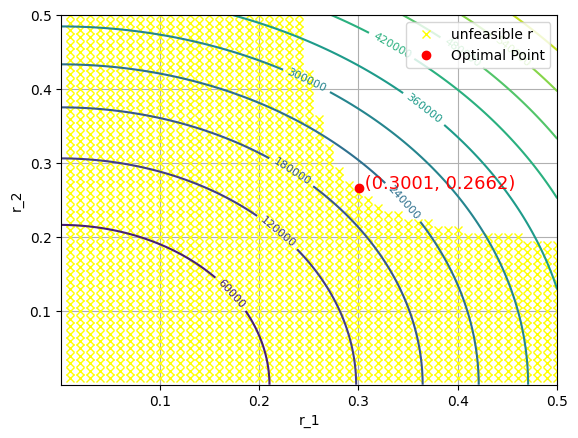

In [18]:

# Validation and contour plot
OK = []
for r1 in np.arange(0.01, 0.51, 0.01):
    for r2 in np.arange(0.01, 0.51, 0.01):
        r = np.array([r1, r2])
        g = nonlincon(r)
        if np.any(np.array(g) < 0):  # Check if any constraint is violated
            OK.append(r)

# Convert OK to NumPy array for easier plotting
OK = np.array(OK)

# Plot infeasible solutions
if OK.size > 0:
    plt.plot(OK[:, 0], OK[:, 1], 'x', label='unfeasible r',color="yellow")

# Draw contour for weight levels
r0_values = np.linspace(0.001, 0.5, 100)
r1_values = np.linspace(0.001, 0.5, 100)
R0, R1 = np.meshgrid(r0_values, r1_values)

# Compute objective values
Z = obj([R0, R1])
# Draw Contour
contour = plt.contour(R0, R1, Z, levels=10, cmap='viridis')
plt.clabel(contour, inline=True, fontsize=8)

# Mark the optimal point
plt.plot(xBest[0], xBest[1], 'ro', label='Optimal Point')
plt.text(
    xBest[0], xBest[1],
    f" ({xBest[0]:.4f}, {xBest[1]:.4f})",
    color='red', fontsize=13
)

# Plot settings
plt.xlabel('r_1')
plt.ylabel('r_2')
plt.legend()
plt.grid()
plt.show()
